## Metin Görseleştirme

#### Gerekli Kütüphaneler

In [1]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import  xgboost, textblob, string
from keras.preprocessing import text, sequence
import seaborn as sns
from transformers import pipeline
from keras import layers, models, optimizers
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df=pd.read_csv("pse_isr_reddit_comments.csv")

In [3]:
df.head()

,comment_id,score,self_text,subreddit,created_time
0,k5480sx,1,Exactly! I can remember the humanitarian aid s...,worldnews,2023-10-16 19:39:01
1,k547q14,1,*We are the only part of the World that has Fr...,Palestine,2023-10-16 19:36:58
2,k547elf,1,"I don’t make Israeli strategy, nor am I Israel...",worldnews,2023-10-16 19:34:47
3,k54742r,1,These people didn't vote Hamas in or something...,worldnews,2023-10-16 19:32:44
4,k5473zi,1,We don't care what you do. We just want to liv...,worldnews,2023-10-16 19:32:43


#### Büyük-Küçük harf dönüşümü

In [4]:
df.tail()

,comment_id,score,self_text,subreddit,created_time
189626,k3sdwfc,42,US. This is bullshit,Palestine,2023-10-07 05:20:11
189627,k3sdixt,1,I am in the United States and it has the dotte...,Palestine,2023-10-07 05:17:23
189628,k3sccp2,54,In which country are you?\nSometimes maps adap...,Palestine,2023-10-07 05:08:26
189629,k3ritvj,116,You can't give up on something you only preten...,worldnews,2023-10-07 01:46:05
189630,k3riboh,30,&gt; The head of Islamic Jihad denounced Arab ...,worldnews,2023-10-07 01:42:58


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189631 entries, 0 to 189630
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    189631 non-null  object
 1   score         189631 non-null  int64 
 2   self_text     189631 non-null  object
 3   subreddit     189631 non-null  object
 4   created_time  189631 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.2+ MB


In [6]:
df['self_text'] = df['self_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#### Noktalama işaretleri kaldırma

In [7]:
df['self_text'] = df['self_text'].str.replace('[^\w\s]','')

#### Sayılar kaldırma

In [8]:
df['self_text'] = df['self_text'].str.replace('\d','')

#### Durdurucu kelimeler(the,a ,an,he,she wayy,şhtt,)

In [9]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['self_text'] = df['self_text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Seyreklerin silinmesi

In [10]:
# 1000 'den az olan kelimler silinecek

sil = pd.Series(' '.join(df['self_text']).split()).value_counts()[-1000:]
df['self_text'] = df['self_text'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))

#### Lemmatization

In [11]:
### her bir kelmenin kökünü bulmak için kullanılır

In [12]:
#nltk.download('wordnet')  // eğer word yüklü değilse
from textblob import Word
df['self_text'] = df['self_text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 

In [13]:
df['self_text'].head(10)

0    exactly! remember humanitarian aid streaming s...
1    *we part world freedom speech!* - person exerc...
2    don’t make israeli strategy, israeli jewish. b...
3    people vote hamas something, can't exactly muc...
4    care do. want live world _literally_ impossibl...
5    hamas exists israeli control area. it’s occupa...
6    i'll forward time find it. interview saw weeke...
7    inverte flag gonna still right. stop think sin...
8    wish medium would talk particular abuse afflic...
9    blinded social medium fake news. changed side ...
Name: self_text, dtype: object

In [14]:
type(df['self_text'])

pandas.core.series.Series

In [15]:
text = df["self_text"][0] ## sadece bir kısım veri ile  kelime bulutu yapmak

In [16]:
wordcloud = WordCloud().generate(text)

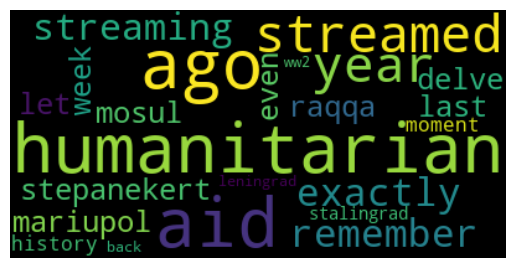

In [17]:
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

#### Tüm veri ile kelime bulutu yapmak

In [18]:
CountText=df['self_text'].to_string()
print(f"Girilen metinde {len(CountText)} kelime bulunuyor.")

Girilen metinde 11377859 kelime bulunuyor.


In [19]:
text = " ".join(i for i in df.self_text)

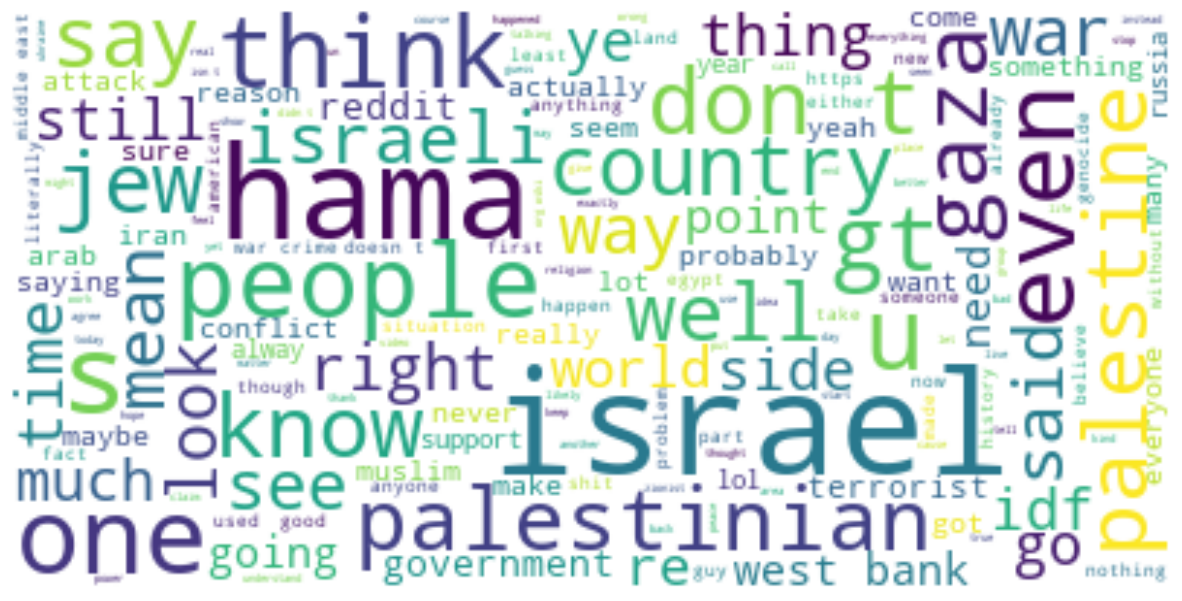

In [20]:
wordcloud = WordCloud(max_font_size = 50, 
                     background_color = "white").generate(text)
plt.figure(figsize = [15,15])
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [21]:
## şimdi bunu bir png dosyasına çevirelim

In [22]:
wordcloud.to_file("kelime_bulutu.png");

# Sentiment Analizi 

In [23]:
df=pd.read_csv("pse_isr_reddit_comments.csv")

In [24]:
df.head()

,comment_id,score,self_text,subreddit,created_time
0,k5480sx,1,Exactly! I can remember the humanitarian aid s...,worldnews,2023-10-16 19:39:01
1,k547q14,1,*We are the only part of the World that has Fr...,Palestine,2023-10-16 19:36:58
2,k547elf,1,"I don’t make Israeli strategy, nor am I Israel...",worldnews,2023-10-16 19:34:47
3,k54742r,1,These people didn't vote Hamas in or something...,worldnews,2023-10-16 19:32:44
4,k5473zi,1,We don't care what you do. We just want to liv...,worldnews,2023-10-16 19:32:43


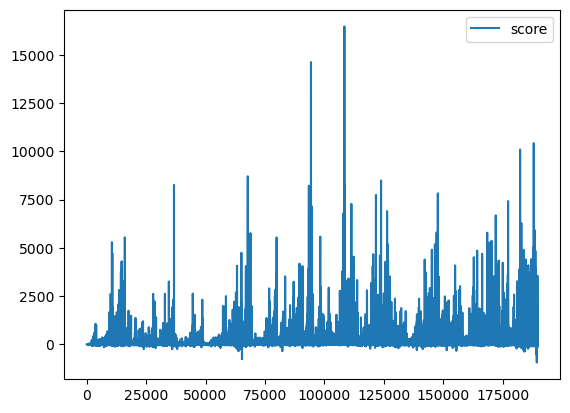

In [25]:
df[["score"]].plot();

In [26]:
# bölmeler oluşturmak sütun için
bins = [-1000, 0, 1, 5, 10, 17000]

# etiketler oluşturuldu bölmeler için
labels = ['Strongly Negative', 'Negative', 'Neutral', 'Positive', 'Strongly Positive']

In [27]:
import eng_spacysentiment
nlp = eng_spacysentiment.load()
sentiment = {'positive': [],
            'negative': [],
            'neutral': []}
for value in df.itertuples():
    doc = nlp(value.self_text)
    sentiment['positive'].append(doc.cats['positive'])
    sentiment['negative'].append(doc.cats['negative'])
    sentiment['neutral'].append(doc.cats['neutral'])

In [28]:
df.head()

,comment_id,score,self_text,subreddit,created_time
0,k5480sx,1,Exactly! I can remember the humanitarian aid s...,worldnews,2023-10-16 19:39:01
1,k547q14,1,*We are the only part of the World that has Fr...,Palestine,2023-10-16 19:36:58
2,k547elf,1,"I don’t make Israeli strategy, nor am I Israel...",worldnews,2023-10-16 19:34:47
3,k54742r,1,These people didn't vote Hamas in or something...,worldnews,2023-10-16 19:32:44
4,k5473zi,1,We don't care what you do. We just want to liv...,worldnews,2023-10-16 19:32:43


In [29]:
# bölmeler oluşturmak sütun için
bins = [-1000, 0, 1, 5, 10, 17000]

# etiketler oluşturuldu bölmeler için
labels = ['Strongly Negative', 'Negative', 'Neutral', 'Positive', 'Strongly Positive']

# Create a new column and assign the binned values
df.insert(2, 'score_label', pd.cut(df['score'], bins=bins, labels=labels))
df.insert(4, 'positive', sentiment['positive'])
df.insert(5, 'negative', sentiment['negative'])
df.insert(6, 'neutral', sentiment['neutral'])

In [30]:
data = pd.DataFrame()

data["score_label"]=df["score_label"]
data["self_text"]=df["self_text"]

In [31]:
data.head()

,score_label,self_text
0,Negative,Exactly! I can remember the humanitarian aid s...
1,Negative,*We are the only part of the World that has Fr...
2,Negative,"I don’t make Israeli strategy, nor am I Israel..."
3,Negative,These people didn't vote Hamas in or something...
4,Negative,We don't care what you do. We just want to liv...


In [32]:
data['score_label'].value_counts()

score_label
Negative             63168
Strongly Positive    45408
Neutral              42383
Strongly Negative    20783
Positive             17889
Name: count, dtype: int64

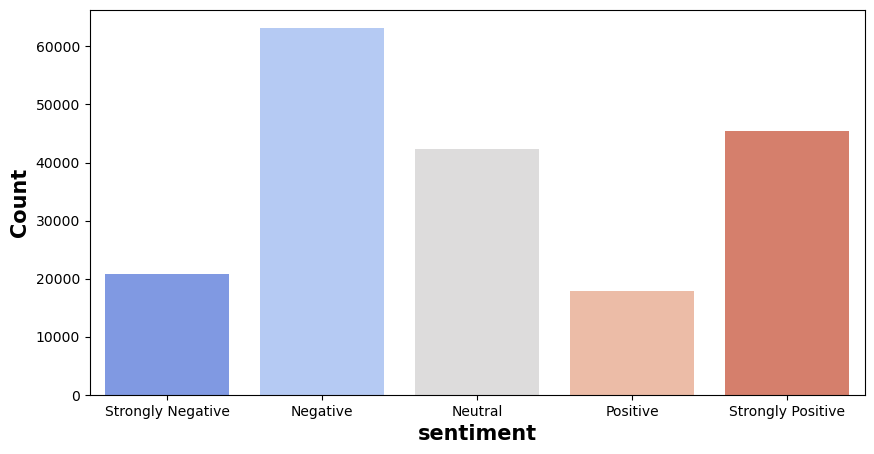

In [33]:
plt.figure(figsize=(10,5))
sns.countplot(x = 'score_label',data=data,palette ='coolwarm')
plt.xlabel("sentiment",fontweight='bold',size=15)
plt.ylabel("Count",fontweight='bold',size=15)
plt.show()

In [34]:
#################################

In [35]:
sent_pipeline = pipeline("sentiment-analysis") 


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [38]:
sent_pipelineJ('')  ## sadece bir soru sormuşuz :(( 

[{'label': 'POSITIVE', 'score': 0.9998227953910828}]

In [37]:
kim kazancak bu israil-gaze savaşında'

SyntaxError: unterminated string literal (detected at line 1) (3571009246.py, line 1)